In [44]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
from sklearn.model_selection import train_test_split

# Lab 07 - Virtual Screening Problem
In this lab, your task is to create a predictive Machine Learning model that will be deployed as a Virtual Screening (VS) tool. VS is a powerful computational technique used to evaluate the desired biological activity of thousands of drug molecules. By using this technology, we can significantly reduce the time and expenses involved in the drug development pipeline.

In this lab, you will take on the role of a **Machine Learning Engineer** at an innovative Pharmaceutical company. Your team has been working on identifying new treatments for Chagas disease, and your job is to train a machine learning model that can be used as a virtual screening tool to identify potential candidates for the treatment. After conducting some research, you've found a promising dataset of a detailed [_in vivo_](https://ridgewayresearch.co.uk/parasite-diagnostics-laboratory/in-vitro-in-vivo-assays/#:~:text=In%20vivo%20assays%20are%20used,Assess%20their%20safety) assay where thousands of molecules were evaluated to determine their biological activity in suppressing Trypanosoma Cruzi, the causal agent of Chagas disease. With your team, you've decided that this high-quality dataset can be used to train the machine learning model.

Your team of **Feature Engineers** has extracted different types of molecular features that describe these drug molecules and has generated the following dataset: `cruzi_comp_activity_molecular_features.csv`. However, they've also informed you that for some molecules, some molecular features, specifically "NumberOfAromaticRings" and "TPSA", couldn't be extracted. It's now up to you, the ML Engineer, to decide how to handle this issue.

The outcome of the in vivo assay is recorded in the "EC50" column of the dataset. According to the report, any molecule with an EC50 activity of less than or equal to 1 $\mu M$ is considered active. This means that for a molecule to be deemed active, its EC50 value must be no greater than 1 $\mu M$. These active molecules can then be prioritized as potential candidates for a new treatment against Chagas disease.

You will need to analyze the data, consider the problem at hand, and decide whether to train a regression or a classification model. You will also need to select a correct and relevant performance metric for your model(s).

Please note that you are free to use any of the algorithms that were covered in the class for both regression and classification tasks. However, you must not import any other classifiers, such as Random Forests, XgBoost, or any other algorithm not covered in the class.

In [45]:
# import the data
mol_df = pd.read_csv('cruzi_comp_activity_molecular_features.csv')
mol_df.head()

,CID,NumberOfRings,NumberOfAromaticRings,ALogP,MolecularWeight,RotatableBondCount,HydrogenBondAcceptorCount,HydrogenBondDonorCount,TPSA,XlogP,EC50
0,1201,4,2.0,0.00,370.43884,2,5,1,65.0,3.8,2.280
1,3610,1,1.0,0.00,194.27012,5,2,2,40.5,3.5,0.781
2,3793,7,5.0,0.00,705.63342,11,9,0,101.0,5.7,0.100
3,4497,2,1.0,0.00,418.44034,9,8,1,120.0,3.1,1.314
4,7573,2,2.0,4.22,226.31682,4,2,2,24.1,4.0,2.524


## Data Cleaning and Splitting

Since the information given tells us the dataset is mainly divided in two classes (active or inactive cells), I think the best approach would be a Classifier model. 

I believe a Regression model would be useful if we knew more information about the data (for example, is it better if the active cell is close or far from being equal to 1?), since we would be able to order the cells from best to worst, or extract other info.

So, I'll prepare my dataset to test classification models.

In [46]:
# Deleting the useless first column
mol_df.drop(columns=["CID"], inplace = True)

# We also want to treat invalid values
# print("Unique values from NumberOfAromaticRings:", np.unique(mol_df["NumberOfAromaticRings"]), "\n")
# print("Unique values from TPSA:\n", np.unique(mol_df["TPSA"]), sep="")

# As you can see in the prints above, both columns have nan values where we couldn't get the data, so let's see how many
print("Number of nans in NumberOfAromaticRings:", np.count_nonzero(np.isnan(mol_df["NumberOfAromaticRings"])))
print("Number of nans in TPSA:", np.count_nonzero(np.isnan(mol_df["TPSA"])))

# There's actually very few compared to the size of the dataset, so in this case we can just drop these lines
print("Dataset shape before removing:", mol_df.shape)
mol_df.dropna(inplace = True)
print("Dataset shape after removing:", mol_df.shape)

Number of nans in NumberOfAromaticRings: 10
Number of nans in TPSA: 10
Dataset shape before removing: (3854, 10)
Dataset shape after removing: (3844, 10)


In [47]:
# Now, let's split the dataset:
x, t = mol_df.values[:, :-1], mol_df.values[:, -1]

# I want to split the dataset for classification models, so let's define the target for a binary classification:
t[t <= 1] = 1
t[t > 1] = 0
# Being 0 = inactive cells and 1 = active cells

x_train, x_temp, t_train, t_temp = train_test_split(x, t, test_size = 0.4)
x_valid, x_test, t_valid, t_test = train_test_split(x_temp, t_temp, test_size = 0.5)
# Splitting with a 20% validation set, and 20% testing set

## Importing Models and Defining Functions

I want to test classification with KNN, Linear Discriminant and Logistic Regression models.

Importing the main classes for the models:

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score

Defining functions to plot the ROC Curve:

In [49]:
def get_fpr_tpr(predicted_values, true_labels, threshold):
    prediction_vector = np.zeros(true_labels.size)
    tp, fp, tn, fn = 0, 0, 0, 0  
    
    for i in range(0, true_labels.size):
        if predicted_values[i] > threshold:
            prediction_vector[i] = 1

        if prediction_vector[i] > true_labels[i]: fp += 1
        elif prediction_vector[i] < true_labels[i]: fn += 1
        elif prediction_vector[i] == 1: tp += 1
        else: tn += 1

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn) 
    return fpr, tpr 

def roc_dataframe(predicted_values, true_labels):
    fpr_list = []
    tpr_list = []

    for datapoint in predicted_values:
        fpr, tpr = get_fpr_tpr(predicted_values, true_labels, datapoint)
        fpr_list.append(fpr)
        tpr_list.append(tpr)

    dataframe = pd.DataFrame({"FPR": fpr_list, "TPR": tpr_list})
    return dataframe

## Fitting and Validating

In [50]:
# your code goes here... You can add as many code cells as you wish.
fisher = LinearDiscriminantAnalysis()
logit = LogisticRegression(max_iter = 1000) # We need to increase the max iterations to correctly converge 

# Fitting the models
fisher.fit(x_train, t_train)
logit.fit(x_train, t_train)

LogisticRegression(max_iter=1000)

KNeighborsClassifier(n_neighbors=7)

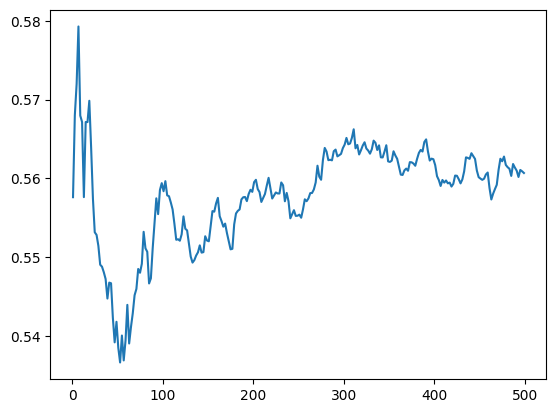

In [54]:
# For KNN, let's decide the best K:
k_range = []
scores = []

for k in range(1, 500, 2):
    # For each k, we create a different classifier and take it's score
    knn = KNeighborsClassifier(k) 
    knn.fit(x_train, t_train)
    knn_proba = knn.predict_proba(x_valid)[:, 1]

    scores.append(roc_auc_score(t_valid, knn_proba))
    k_range.append(k)

# We can plot the scores against the k values just for visualization
sns.lineplot(x=k_range, y=scores)

# Finally, let's take the best k and fit it
k = k_range[np.argmax(scores)]
knn = KNeighborsClassifier(k)
knn.fit(x_train, t_train)

<Axes: xlabel='FPR', ylabel='TPR'>

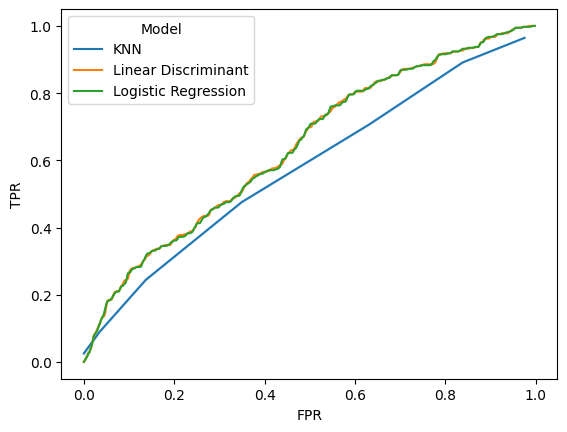

In [55]:
# Now, let's predict the validation set and build the ROC Curve to compare models
knn_proba = knn.predict_proba(x_valid)[:, 1]
fisher_proba = fisher.predict_proba(x_valid)[:, 1]
logit_proba = logit.predict_proba(x_valid)[:, 1]

knn_df = roc_dataframe(knn_proba, t_valid)
fisher_df = roc_dataframe(fisher_proba, t_valid)
logit_df = roc_dataframe(logit_proba, t_valid)

# Adding an extra column to plot all the roc curves together
knn_df["Model"] = ["KNN"]*knn_df.shape[0]
fisher_df["Model"] = ["Linear Discriminant"]*fisher_df.shape[0]
logit_df["Model"] = ["Logistic Regression"]*logit_df.shape[0]
# Plotting the ROC
roc_df = pd.concat([knn_df, fisher_df, logit_df], ignore_index = True)
sns.lineplot(data = roc_df, x="FPR", y="TPR", hue = "Model")

In [57]:
knn_auroc = roc_auc_score(t_valid, knn_proba)
print(f"The AUROC for the K-Nearest Neighbors is: {knn_auroc}")

fisher_auroc = roc_auc_score(t_valid, fisher_proba)
print(f"The AUROC for the Linear Discriminant Analysis is: {fisher_auroc}")

logit_auroc = roc_auc_score(t_valid, logit_proba)
print(f"The AUROC for the Logistic Regression is: {logit_auroc}")

The AUROC for the K-Nearest Neighbors is: 0.5792787054103871
The AUROC for the Linear Discriminant Analysis is: 0.6405114930066139
The AUROC for the Logistic Regression is: 0.6396983085763851


As we can see, the Linear Discriminant outperforms the other classifiers with a small advantage, so let's use it to predict our testing set!

## Training and Testing the Model

The AUROC for the Final Linear Discriminant Analysis is: 0.661336379211879


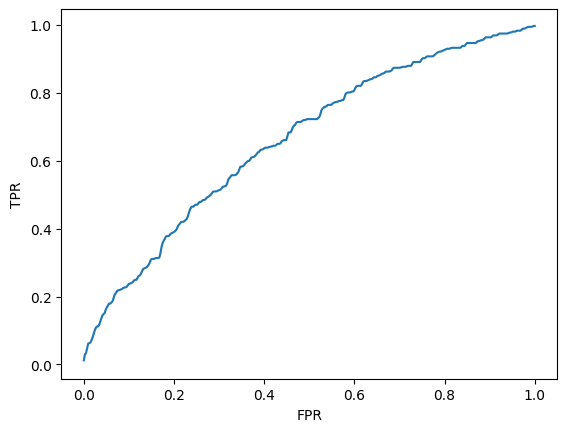

In [58]:
x_final_train = np.vstack((x_train, x_valid))
t_final_train = np.hstack((t_train, t_valid))

fisher.fit(x_final_train, t_final_train)
fisher_proba = fisher.predict_proba(x_test)[:, 1]

# Plotting the ROC
fisher_df = roc_dataframe(fisher_proba, t_test)
sns.lineplot(data = fisher_df, x="FPR", y="TPR")

fisher_auroc = roc_auc_score(t_test, fisher_proba)
print(f"The AUROC for the Final Linear Discriminant Analysis is: {fisher_auroc}")

# Round 2
After conducting some initial experiments, your team is not entirely satisfied with the obtained results. Several factors could be affecting the performance at this stage. One possible reason could be that the dataset size is too small, with insufficient assessed compounds. Another possible cause could be that the features used are not adequately descriptive. To address this, you request the feature engineers to extract additional features for the compounds. They have generated a new dataset, named `cruzi_comp_activity_structural_features.csv`, which includes the chemical substructures present in each compound that are known to be informative of biological activity.

Your next task is to assess the effectiveness of these newly extracted features. It is crucial to determine if they improve the model's performance. Additionally, you could experiment with a hybrid approach by combining both sets of features to determine which approach yields the best results.

In [65]:
# load the dataset
struct_df = pd.read_csv('cruzi_comp_activity_structural_features.csv')
struct_df.drop(columns=["CID"], inplace = True)
# This time we have no invalid values to treat 

struct_df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,EC50
0,1,0,1,1,1,0,1,0,0,0,...,1,1,1,1,0,0,1,1,0,2.280
1,1,0,1,1,1,1,1,1,1,1,...,0,1,1,0,1,1,0,1,0,0.100
2,1,0,0,0,1,1,1,0,0,1,...,1,0,0,0,0,1,0,0,0,2.524
3,0,0,1,0,1,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0.524
4,1,0,1,1,1,1,0,0,1,0,...,1,1,0,0,0,1,0,0,0,2.112


I'm going to repeat all the validation proccess, to see if any of the other models will perform better this time. 

KNeighborsClassifier(n_neighbors=7)

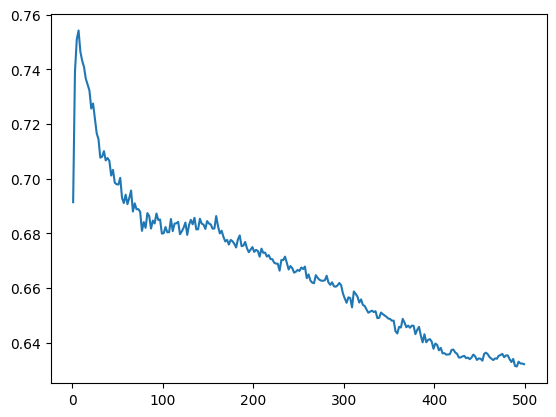

In [66]:
x2, t2 = struct_df.values[:, :-1], struct_df.values[:, -1]

t2[t2 <= 1] = 1
t2[t2 > 1] = 0

x2_train, x2_temp, t2_train, t2_temp = train_test_split(x2, t2, test_size = 0.4)
x2_valid, x2_test, t2_valid, t2_test = train_test_split(x2_temp, t2_temp, test_size = 0.5)

fisher2 = LinearDiscriminantAnalysis()
logit2 = LogisticRegression(max_iter = 1000) # We need to increase the max iterations to correctly converge 

# Fitting the models
fisher2.fit(x2_train, t2_train)
logit2.fit(x2_train, t2_train)

# For KNN, let's decide the best K:
k_range = []
scores = []

for k in range(1, 500, 2):
    # For each k, we create a different classifier and take it's score
    knn2 = KNeighborsClassifier(k) 
    knn2.fit(x2_train, t2_train)
    knn2_proba = knn2.predict_proba(x2_valid)[:, 1]

    scores.append(roc_auc_score(t2_valid, knn2_proba))
    k_range.append(k)

# We can plot the scores against the k values just for visualization
sns.lineplot(x=k_range, y=scores)

# Finally, let's take the best k and fit it
k = k_range[np.argmax(scores)]
knn2 = KNeighborsClassifier(k)
knn2.fit(x2_train, t2_train)

The AUROC for the K-Nearest Neighbors is: 0.7542329868442423
The AUROC for the Linear Discriminant Analysis is: 0.6673163337123058
The AUROC for the Logistic Regression is: 0.6676140977748904


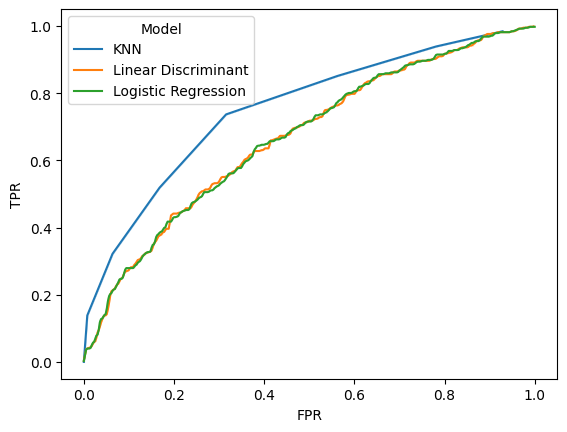

In [67]:
# Now, let's predict the validation set and build the ROC Curve to compare models
knn2_proba = knn2.predict_proba(x2_valid)[:, 1]
fisher2_proba = fisher2.predict_proba(x2_valid)[:, 1]
logit2_proba = logit2.predict_proba(x2_valid)[:, 1]

knn2_df = roc_dataframe(knn2_proba, t2_valid)
fisher2_df = roc_dataframe(fisher2_proba, t2_valid)
logit2_df = roc_dataframe(logit2_proba, t2_valid)

# Adding an extra column to plot all the roc curves together
knn2_df["Model"] = ["KNN"]*knn2_df.shape[0]
fisher2_df["Model"] = ["Linear Discriminant"]*fisher2_df.shape[0]
logit2_df["Model"] = ["Logistic Regression"]*logit2_df.shape[0]

# Plotting the ROC
roc2_df = pd.concat([knn2_df, fisher2_df, logit2_df], ignore_index = True)
sns.lineplot(data = roc2_df, x="FPR", y="TPR", hue = "Model")

knn2_auroc = roc_auc_score(t2_valid, knn2_proba)
print(f"The AUROC for the K-Nearest Neighbors is: {knn2_auroc}")

fisher2_auroc = roc_auc_score(t2_valid, fisher2_proba)
print(f"The AUROC for the Linear Discriminant Analysis is: {fisher2_auroc}")

logit2_auroc = roc_auc_score(t2_valid, logit2_proba)
print(f"The AUROC for the Logistic Regression is: {logit2_auroc}")

As a result, we can observe that KNN has performed as the best classificator for the second dataset!

Not only that, but we can see a relatively good increase in performance by all the three models, proving that the second dataset is, indeed, beter to describe and predict the points. Finally, we can train our model and make a final test in it.

## Training and Testing the Model

The AUROC for the Final K-Nearest Neighbours is: 0.7731802896349731


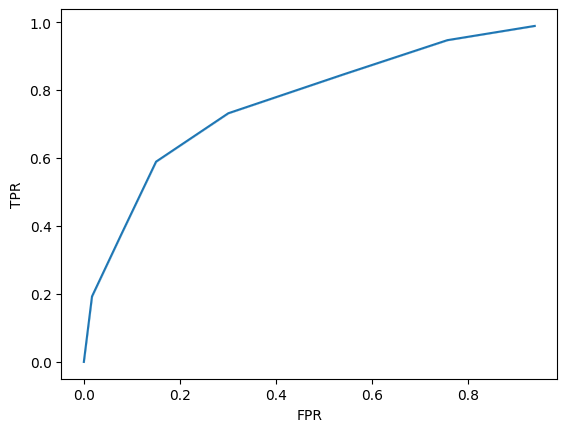

In [69]:
x2_final_train = np.vstack((x2_train, x2_valid))
t2_final_train = np.hstack((t2_train, t2_valid))

knn2.fit(x2_final_train, t2_final_train)
knn2_proba = knn2.predict_proba(x2_test)[:, 1]

# Plotting the ROC
knn2_df = roc_dataframe(knn2_proba, t2_test)
sns.lineplot(data = knn2_df, x="FPR", y="TPR")

knn2_auroc = roc_auc_score(t2_test, knn2_proba)
print(f"The AUROC for the Final K-Nearest Neighbours is: {knn2_auroc}")